# Getting Started with Datacube Stats
| Author(s):  | [Arapaut Sivaprasad](mailto:Sivaprasad.Arapaut@ga.gov.au)|
|----------|----------------|
| Created: | May 17, 2018 |
| Last edited: | May 17, 2018 |
| Acknowledgements: | Imam Alam|

## Data Cube Statistics Tools
Data Cube Statistics is a an application used to calculate large scale temporal statistics on data stored using an Open Data Cube (ODC) installation. It provides a command line application which uses a YAML configuration file to specify the data range and statistics to calculate.

In [10]:
%matplotlib inline
import datacube
import matplotlib.pyplot as plt
from skimage import exposure
import numpy as np

import yaml
from datacube_stats import StatsApp
from datacube import Datacube
import matplotlib.gridspec as gridspec

## Configuration File
The entire config for this application resides in a YAML file as given below. More details about its components later...

In [11]:
def main():
    config_yaml = """
    sources:
      - product: ls8_nbar_albers
        measurements: [red, green, blue]
        group_by: solar_day

    date_ranges:
        start_date: 2014-06-01
        end_date: 2014-07-01

    storage:
        # this driver enables in-memory computation
        driver: xarray

        crs: EPSG:3577
        tile_size:
            x: 40000.0
            y: 40000.0
        resolution:
            x: 25
            y: -25
        chunking:
            x: 200
            y: 200
            time: 1
        dimension_order: [time, y, x]

    computation:
        chunking:
            x: 800
            y: 800

    input_region:
          longitude: [149.05, 149.17]
          latitude: [-35.25, -35.35]

    output_products:
        - name: nbar_mean
          statistic: simple
          statistic_args:
               reduction_function: mean
    """
    return config_yaml
#    print(config_yaml)
    # or manually creating a config dictionary works too

### Create and load the config
Instead of a text file as above, the whole data can be specified as a dictionary object.

In [12]:
    config_yaml = main()
    config = yaml.load(config_yaml)

#    print(yaml.dump(config, indent=4))

### Define the datacube stats application

In [13]:
dc = Datacube()
app = StatsApp(config, dc.index)

### Generate the tasks
Do not know yet what the tasks are. Will update it as I learn more!

This example is taking a simple mean of the data spread over the date range. There are other methods that are more complex.

In [14]:
#print('generating tasks')
tasks = app.generate_tasks()


### Run the tasks

In [15]:
    print('Running tasks. May take some time. Be patient!')
    for task in tasks:
        # this method is only available for the xarray output driver
        output = app.execute_task(task)
        ds = output.result['nbar_mean']
#        print(ds)


Running tasks. May take some time. Be patient!


### Function to plot as three bands

In [16]:
'''
    Last modified: April 2018
    Author: Mike Barnes
    Modified by: Claire Krause, Cate Kooymans, Robbi Bishop-Taylor, Sivaprasad Arapaut

Parameters for three_band_image():

Inputs:

    ds - dataset containing the bands to be plotted
    bands - list of three bands to be plotted

Optional:

    time - Index value of the time dimension of ds to be plotted.
        This index refers to the scenes captured, depending on your date range.
    figsize - dimensions for the output figure.
    contrast_enhance - determines the transformation for plotting onto RGB. If contrast_enhance = true, exposure.equalize_hist is used to transform the data. Else, the data are standardised relative to reflectance = 5000.
    title - string for the plot title. If nothing is given, it will print the names of the bands being plotted.
    projection - options are 'projected' or 'geographic'; determines if the image is in degrees or northings.
        The terms easting and northing are geographic Cartesian coordinates for a point. Easting refers to the eastward-measured distance (or the x-coordinate), while northing refers to the northward-measured distance (or the y-coordinate). Easting and northing coordinates are commonly measured in metres from the axes of some horizontal datum.
'''
def three_band_image(ds, bands, time=0, figsize=[10, 10], contrast_enhance=True, title='My Plot', projection='projected'):

    # Get the number of scenes and the number of x and y coordinates
    t, y, x = ds[bands[0]].shape

    # Initialise a numpy.ndarray class object with 0's
    rawimg = np.zeros((y, x, 3), dtype=np.float32)

    # Populate the rawimg array with actual values. These are taken from all specified bands
    for i, colour in enumerate(bands):
        rawimg[:, :, i] = ds[colour][time].values

    # NBAR-T data inserts a missing value (-999) into the dataset to denote a terrain shadow. 
    # It should be converted to a NaN value before using this data to avoid treating it as a valid value.
    rawimg[rawimg == -999] = np.nan
    
    # Enhance the picture quality by applying 'histogram_equalisation'
    if contrast_enhance:
        img_toshow = exposure.equalize_hist(rawimg, mask=np.isfinite(rawimg))
    else:
        img_toshow = rawimg / 5000
        
    # Plot the data
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_toshow)
    
    # Build the X and Y axes
    ax = plt.gca()

    ax.set_title(str(ds.time[time].values), fontweight='bold', fontsize=16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    
    ax.set_xlabel('Eastings', fontweight='bold')
    ax.set_ylabel('Northings', fontweight='bold')


### Plot it as a grid first

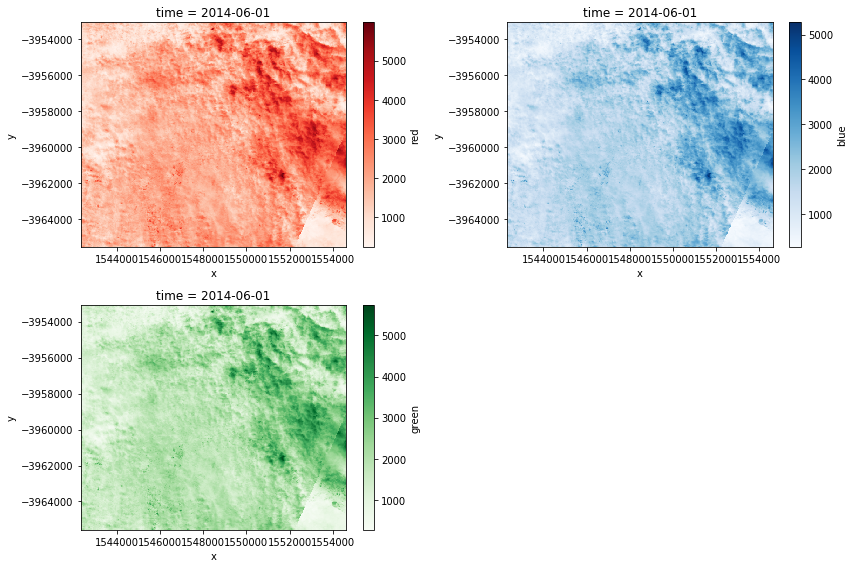

In [17]:
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
ds.red.isel(time=0).plot(cmap='Reds')

ax2=plt.subplot(gs[1,0])
ds.green.isel(time=0).plot(cmap='Greens')

ax3=plt.subplot(gs[0,1])
ds.blue.isel(time=0).plot(cmap='Blues')

plt.tight_layout()
plt.show()

### Plot it as three bands

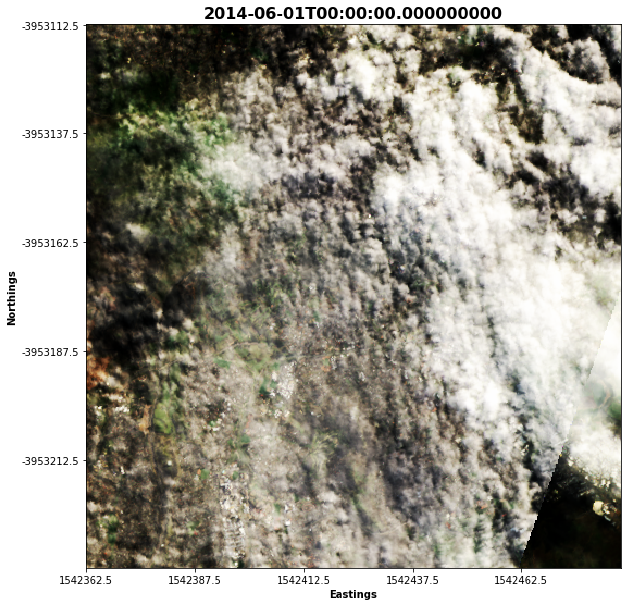

In [18]:
three_band_image(ds, bands = ['red', 'green', 'blue'], time = 0)